In [1]:
%matplotlib inline
# %matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import asdf
import scipy.signal as sig

In [2]:
from pathlib import Path

In [3]:
af = asdf.open('../../data/2.0/asdf/Grims2.0-12.asdf', mode='rw')
af.info()

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 3.2.0
├─history (dict)
│ ├─entries (list)
│ │ └─[0] (HistoryEntry) ...
│ └─extensions (list)
│   └─[0] (ExtensionMetadata) ...
├─pressures (dict)
│ ├─p0 (Reference): <array (unloaded) shape: [24000000] dtype: float64>
│ ├─p1 (Reference): <array (unloaded) shape: [24000000] dtype: float64>
│ └─p3 (Reference): <Reference (unloaded) to 'Grims2.0-12_pressures-p3.asdf#p3'>
└─raw (dict)
  ├─KISTLER09 (Reference): <array (unloaded) shape: [24000000] dtype: float64>
  ├─KISTLER10 (Reference): <array (unloaded) shape: [24000000] dtype: float64>
  ├─KISTLER11 (Reference): <array (unloaded) shape: [24000000] dtype: float64>
  ├─KISTLERold (Reference): <array (unloaded) shape: [24000000] dtype: float64>
  ├─metadata (dict) ...
  └─time (Reference): <array (unloaded) shape: [24000000] dtype: float64>
Some nodes not shown.


In [4]:
md = af['raw']['metadata']
md

{'channels': ['Dev3/ai0', 'Dev3/ai1', 'Dev3/ai2', 'Dev3/ai3'],
 'date': datetime.datetime(2012, 7, 3, 0, 0),
 'device': '6124-2',
 'name': 'Grims2.0-12',
 'names': ['KISTLERold', 'KISTLER09', 'KISTLER10', 'KISTLER11'],
 'pretrigger': 0.0,
 'samples': 24000000,
 'sampling rate': 4000000.0,
 'scales': ['1bar', '1bar', '1bar', '1bar'],
 'slope': 'rising',
 'trigger': False,
 'trigger_level': 0.5,
 'trigger_source': 'PFI0'}

In [5]:
SRATE = md['sampling rate']
SRATE

4000000.0

In [6]:
t = af['raw']['time'][:]

In [7]:
p = af['raw']['KISTLERold'][:]

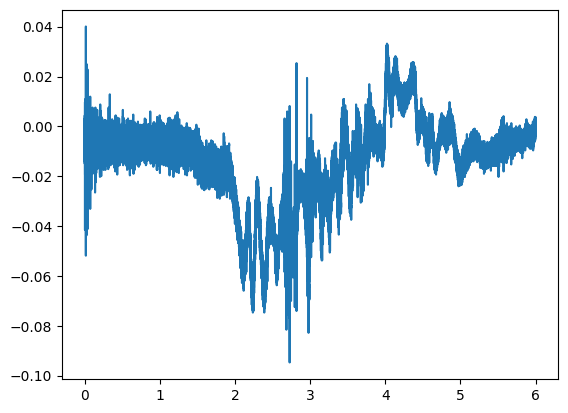

In [8]:
fig, ax = plt.subplots()

ax.plot(t, p)

## Set Up a Highpass Filter

This makes an FIR highpass with a Kaiser window, with a 89dB stop band and 20 Hz cutoff.

In [9]:
ln, beta = sig.kaiserord(89, 20 * 2 / SRATE)
ln, beta

(1129061, 8.84906)

Filter window in seconds

In [10]:
ln / SRATE

0.28226525

Filter's impulse response

In [11]:
taps = sig.firwin(ln, 10 * 2 / SRATE, window=('kaiser', beta), pass_zero=False)

Get the filter's frequency response

In [12]:
f, h = sig.freqz(taps, worN=len(t), fs=SRATE)

### Plot the Filter Characteristics

In [13]:
ln2 = ln // 2
tau = (np.arange(len(taps)) - ln2) / SRATE
ln2, tau[[0, -1]]

(564530, array([-0.1411325,  0.1411325]))

In [14]:
idx = np.zeros(len(taps), dtype=bool)
idx[:ln2 - 10:600] = True
idx[ln2 + 10::600] = True
idx[ln2 - 10:ln2 + 10] = True

In [15]:
idx2 = f < 100
idx3 = idx2.copy()
idx3[[len(idx2[idx2]), -1]] = True

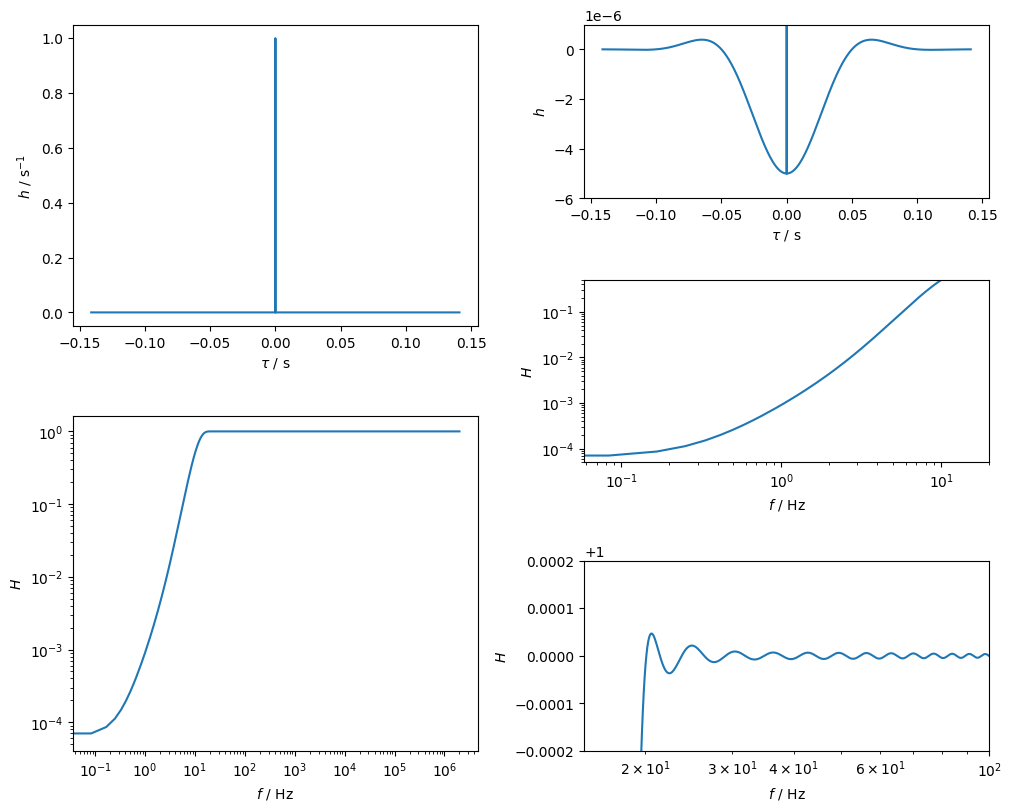

In [16]:
fig, axd = plt.subplot_mosaic(
    [['impulse', 'impulse', 'impin', 'impin'],
     ['impulse', 'impulse', 'impin', 'impin'],
     ['impulse', 'impulse', 'freqin1', 'freqin1'],
     ['freqres', 'freqres', 'freqin1', 'freqin1'],
     ['freqres', 'freqres', 'freqin2', 'freqin2'],
     ['freqres', 'freqres', 'freqin2', 'freqin2']],
    constrained_layout=True
)

ax1 = axd['impulse']
ax1.plot(tau[idx], taps[idx])
ax1.set(
    ylabel='$h\ /\ \mathrm{s^{-1}}$', xlabel=r'$\tau\ /\ \mathrm{s}$'
)
ax4 = axd['impin']
ax4.plot(tau[idx], taps[idx])
ax4.set(
    ylim=(-6e-6, 1e-6),
    xlabel=r'$\tau\ /\ \mathrm{s}$', ylabel=r'$h$'
)
ax2 = axd['freqres']
ax2.plot(f[idx3],  np.abs(h[idx3]))
# ax2.plot(f[~idx][[0, -1]], np.abs(h[~idx][[0, -1]]))
ax2.set(
    xscale='log', yscale='log',
    xlabel=r'$f\ /\ \mathrm{Hz}$', ylabel=r'$H$'
)
ax3 = axd['freqin1']
ax3.plot(f[idx2], np.abs(h[idx2]))
ax3.set(
    xscale='log', yscale='log',
    xlabel=r'$f\ /\ \mathrm{Hz}$', ylabel=r'$H$',
    xlim=(None, 20), ylim=(5e-5, .5)
)
ax4 = axd['freqin2']
ax4.plot(f[idx2], np.abs(h[idx2]))
ax4.set(
    xscale='log',
    # yscale='log',
    xlabel=r'$f\ /\ \mathrm{Hz}$', ylabel=r'$H$',
    xlim=(15, 100), ylim=(1 - 2e-4, 1 + 2e-4)
)
fig.set_size_inches(10, 8)

## Filter the Pressure Signals

### `KISTLERold`, `p0`

In [17]:
pf = sig.fftconvolve(p, taps, mode='same')

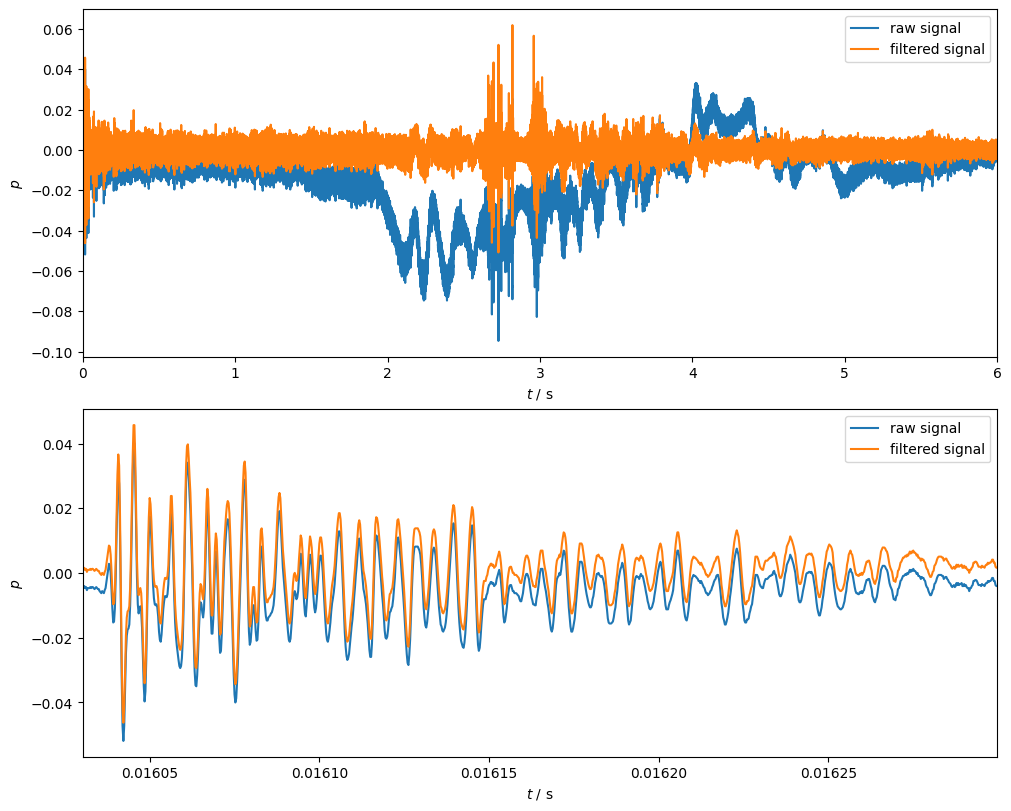

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=2, constrained_layout=True)

ax1.plot(t, p, label='raw signal')
ax1.plot(t, pf, label='filtered signal')
ax1.set(
    xlabel=r'$t\ /\ \mathrm{s}$', ylabel=r'$p$',
    xlim=(0, 6)
)
ax1.legend(loc='upper right')
idx = np.logical_and(t > 1.603e-2, t < 1.630e-2)
ax2.plot(t[idx], p[idx], label='raw signal')
ax2.plot(t[idx], pf[idx], label='filtered signal')
ax2.set(
    xlabel=r'$t\ /\ \mathrm{s}$', ylabel=r'$p$',
    xlim=t[idx][[0, -1]]
)
ax2.legend(loc='upper right')
fig.set_size_inches(10, 8)

In [19]:
af['pressures'] = {}
press = af['pressures']

In [20]:
paf = asdf.AsdfFile(
    uri=str(Path(af.uri[5:]).parent / f"{md['name']}_pressures-p0.asdf")
)

In [21]:
paf['date'] = md['date']
paf['experiment'] = md['name']
paf['srate'] = SRATE
paf['unit'] = 'Pa'
paf['start time'] = 0.0
paf['p0'] = p * 1e5

In [22]:
paf.info()

root (AsdfObject)
├─date (datetime): 2012-07-03 00:00:00
├─experiment (str): Grims2.0-12
├─srate (float): 4000000.0
├─unit (str): Pa
├─start time (float): 0.0
└─p0 (ndarray): shape=(24000000,), dtype=float64


In [23]:
paf.write_to(paf.uri, all_array_compression='zlib')
paf.close()

In [24]:
press['p0'] = {'$ref': f"{md['name']}_pressures-p0.asdf#p0"}

### `KISTLER09`, `p1`

In [25]:
p = af['raw']['KISTLER09'][:]

In [26]:
pf = sig.fftconvolve(p, taps, mode='same')

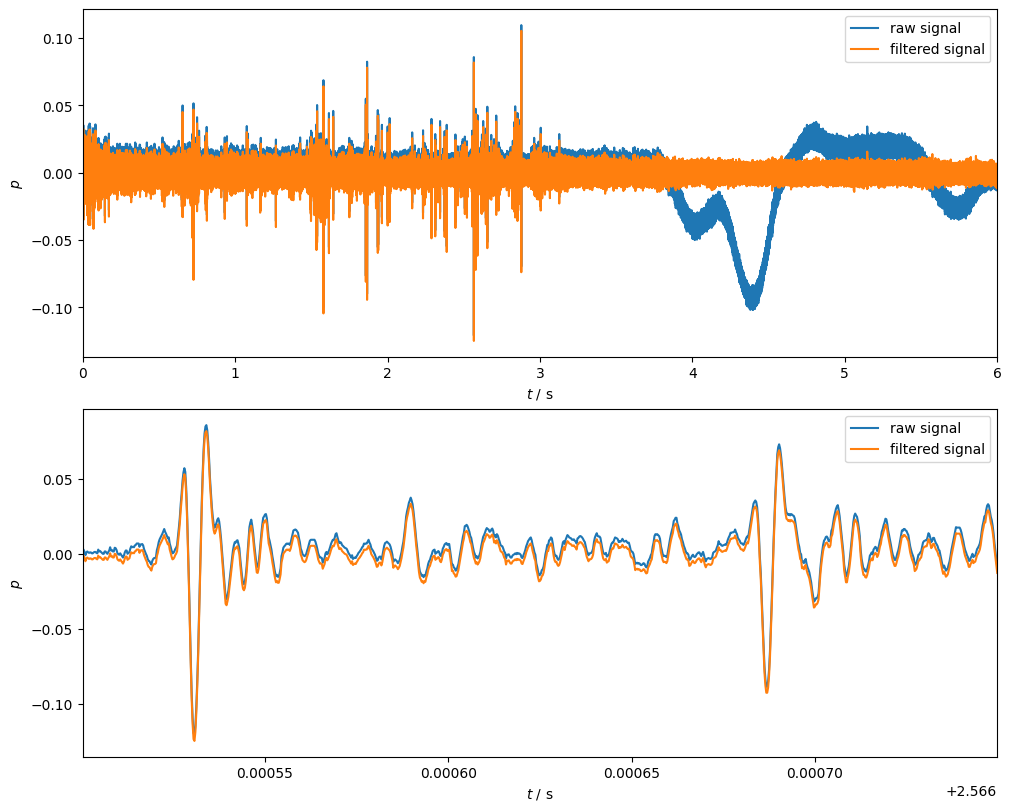

In [27]:
fig, (ax1, ax2) = plt.subplots(nrows=2, constrained_layout=True)

ax1.plot(t, p, label='raw signal')
ax1.plot(t, pf, label='filtered signal')
ax1.set(
    xlabel=r'$t\ /\ \mathrm{s}$', ylabel=r'$p$',
    xlim=(0, 6)
)
ax1.legend(loc='upper right')
idx = np.logical_and(t > 2.5665, t < 2.56675)
ax2.plot(t[idx], p[idx], label='raw signal')
ax2.plot(t[idx], pf[idx], label='filtered signal')
ax2.set(
    xlabel=r'$t\ /\ \mathrm{s}$', ylabel=r'$p$',
    xlim=t[idx][[0, -1]]
)
ax2.legend(loc='upper right')
fig.set_size_inches(10, 8)

In [28]:
paf = asdf.AsdfFile(
    uri=str(Path(af.uri[5:]).parent / f"{md['name']}_pressures-p1.asdf")
)

In [29]:
paf['date'] = md['date']
paf['experiment'] = md['name']
paf['srate'] = SRATE
paf['unit'] = 'Pa'
paf['start time'] = 0.0
paf['p1'] = p * 1e5

In [30]:
paf.info()

root (AsdfObject)
├─date (datetime): 2012-07-03 00:00:00
├─experiment (str): Grims2.0-12
├─srate (float): 4000000.0
├─unit (str): Pa
├─start time (float): 0.0
└─p1 (ndarray): shape=(24000000,), dtype=float64


In [31]:
paf.write_to(paf.uri, all_array_compression='zlib')
paf.close()

In [32]:
press['p1'] = {'$ref': f"{md['name']}_pressures-p1.asdf#p1"}

### `KISTLER11`, `p3`

In [33]:
p = af['raw']['KISTLER11'][:]

In [34]:
pf = sig.fftconvolve(p, taps, mode='same')

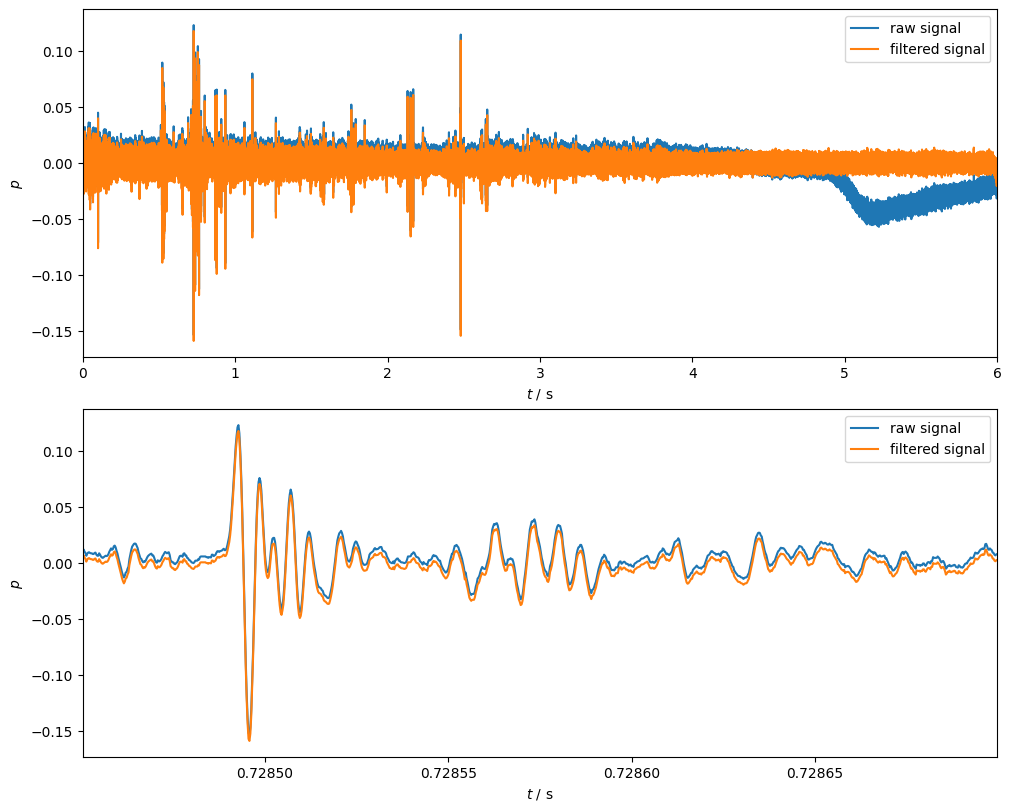

In [35]:
fig, (ax1, ax2) = plt.subplots(nrows=2, constrained_layout=True)

ax1.plot(t, p, label='raw signal')
ax1.plot(t, pf, label='filtered signal')
ax1.set(
    xlabel=r'$t\ /\ \mathrm{s}$', ylabel=r'$p$',
    xlim=(0, 6)
)
ax1.legend(loc='upper right')
idx = np.logical_and(t > 0.72845, t < 0.72870)
ax2.plot(t[idx], p[idx], label='raw signal')
ax2.plot(t[idx], pf[idx], label='filtered signal')
ax2.set(
    xlabel=r'$t\ /\ \mathrm{s}$', ylabel=r'$p$',
    xlim=t[idx][[0, -1]]
)
ax2.legend(loc='upper right')
fig.set_size_inches(10, 8)

In [36]:
paf = asdf.AsdfFile(
    uri=str(Path(af.uri[5:]).parent / f"{md['name']}_pressures-p3.asdf")
)

In [37]:
paf['date'] = md['date']
paf['experiment'] = md['name']
paf['srate'] = SRATE
paf['unit'] = 'Pa'
paf['start time'] = 0.0
paf['p1'] = p * 1e5

In [38]:
paf.info()

root (AsdfObject)
├─date (datetime): 2012-07-03 00:00:00
├─experiment (str): Grims2.0-12
├─srate (float): 4000000.0
├─unit (str): Pa
├─start time (float): 0.0
└─p1 (ndarray): shape=(24000000,), dtype=float64


In [39]:
paf.write_to(paf.uri, all_array_compression='zlib')
paf.close()

In [40]:
press['p3'] = {'$ref': f"{md['name']}_pressures-p3.asdf#p3"}

In [42]:
af.add_history_entry(
    description="Apply a basic filter to raw pressures and store it.\n"
    "- Elements written:\n"
    "  - 'pressures'\n"
    "- Program source: 'anl/prep1_grims2.0-12.ipynb'",
    software={
        "name": "Bismarck Analysis Stack.",
        "author": "The PVL Team",
        "homepage": "https://to.do",
        "version": "0.1"
    }
)

In [44]:
af.find_references()
# af.info(max_rows=50)

In [45]:
af.write_to(af.uri)
af.close()